#--------------------------------------------------------------
# filename : Figure3.ipynb
# Date : 2024-8-27
# contributor : Lianchong Gao
# Python version: 3.10.12
# Platform: Google Colab
#--------------------------------------------------------------

In [45]:
from google.colab import drive
drive.mount('/content/drive')
!pip install openai
!pip install igraph
!pip install scanpy
!pip install gseapy
!pip install mpl_chord_diagram
!pip install palettable
!pip install bbknn
!pip install harmonypy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import scanpy as sc
file_path = '/content/drive/MyDrive/scanpy/GSE179994/adata_new.h5ad'
adata = sc.read(file_path)


file_path = '/content/drive/MyDrive/scanpy/GSE179994/adata_merged.h5ad'
adata_Dsc = sc.read(file_path)

In [47]:
import warnings
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

In [48]:
import os
os.chdir('/content/drive/MyDrive/scanpy/GSE179994/')
import sys
sys.path.append('/content/drive/MyDrive/scanpy/GSE179994')

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import palettable
from sklearn import datasets
import scanpy as sc
import gseapy as gp
from anndata import AnnData
import anndata as ad
import pandas as pd
from scipy.sparse import issparse
import numpy as np
import pooch
from openai import OpenAI
from matplotlib.pyplot import rc_context
import os
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches

In [50]:
sc.settings.set_figure_params(dpi=100)

# Fig.3a

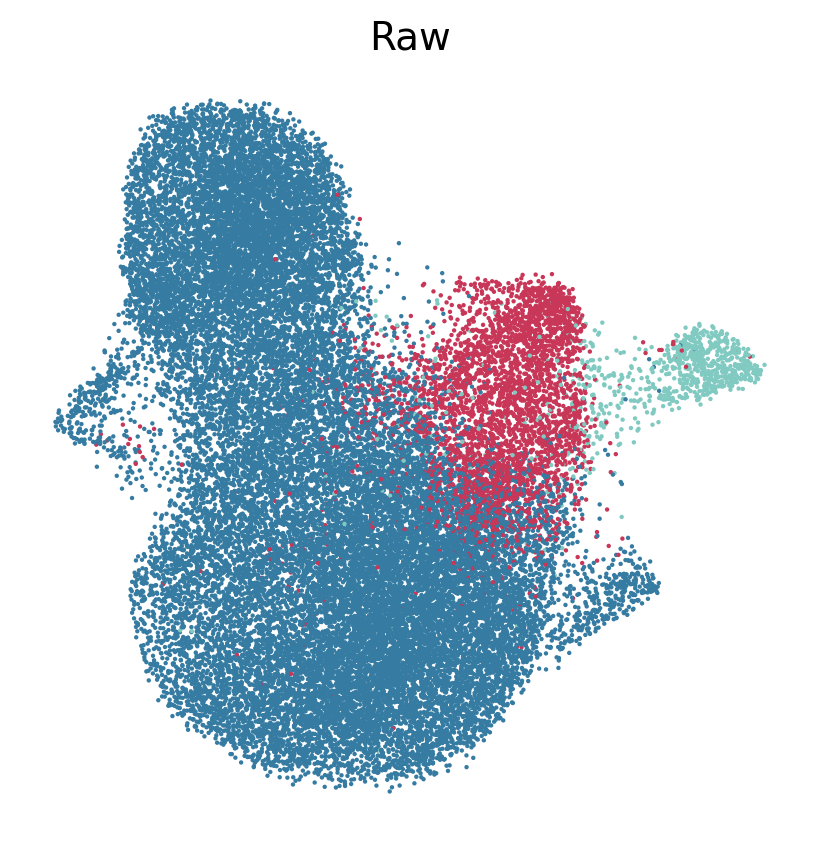

In [51]:
adata.obs['cluster'] = pd.Categorical(adata.obs['cluster'], ordered=True)
custom_palette = ['#357ba2', '#80cac1', '#c83658']

with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata,
        color="cluster",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="Raw",
        palette=custom_palette,
        wspace=0.5,
        add_outline=False,
        size=10,
        legend_loc="right",
        alpha=1
    )

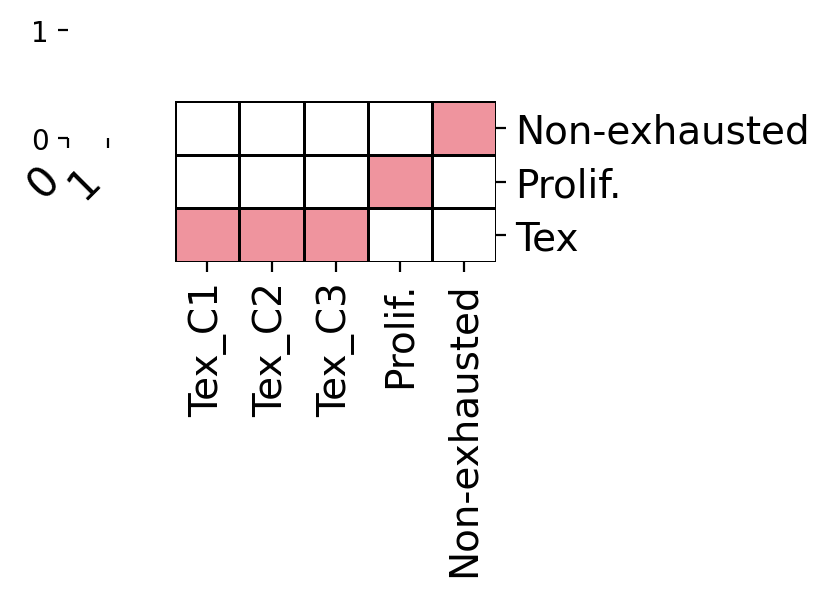

In [52]:
from scipy.stats import hypergeom

def hypergeom_test(adata, group1, group2):
    categories1 = adata.obs[group1].astype('category')
    categories2 = adata.obs[group2].astype('category')
    results = {}
    N = len(adata)

    for cat1 in categories1.cat.categories:
        group1_total = np.sum(categories1 == cat1)

        for cat2 in categories2.cat.categories:
            group2_total = np.sum(categories2 == cat2)
            intersection = np.sum((categories1 == cat1) & (categories2 == cat2))

            M = group2_total
            n = group1_total
            x = intersection
            p_value = hypergeom.sf(x-1, N, M, n)

            results[(cat1, cat2)] = {
                'group1_total': group1_total,
                'group2_total': group2_total,
                'intersection': intersection,
                'p_value': p_value
            }

    return results

def plot_hypergeom_heatmap_clustered(results):
    data = {
        (cat1, cat2): -np.log10(res['p_value'])
        for (cat1, cat2), res in results.items()
    }
    df = pd.Series(data).unstack()
    #custom_order = ['1', '11', '7', '4', '2', '3', '5' ,'6','8', '9', '10', '12', '0']
    custom_order = ['Tex_C1', 'Tex_C2', 'Tex_C3', 'Prolif.', 'Non-exhausted']
    df.index = df.index.map(str)
    df = df.loc[custom_order]
    df = df.clip(upper=5)
    colors = ["#ffffff", "#ef949e"]
    cmap = LinearSegmentedColormap.from_list("custom_orange", colors, N=256)
    cluster_grid = sns.clustermap(df.T, figsize=(4, 3), cmap=cmap,cbar=False,
                                  row_cluster=False, col_cluster=False,
                                   linewidths=0.5, linecolor='black')

    cluster_grid.ax_heatmap.grid(False)
    plt.xticks(rotation=45, ha='right', fontsize='15')
    plt.yticks(fontsize='10')
    plt.title("", fontsize=15, pad=10)
    plt.grid(False)
    plt.show()

results = hypergeom_test(adata_Dsc, 'Dsc', 'cluster')
plot_hypergeom_heatmap_clustered(results)

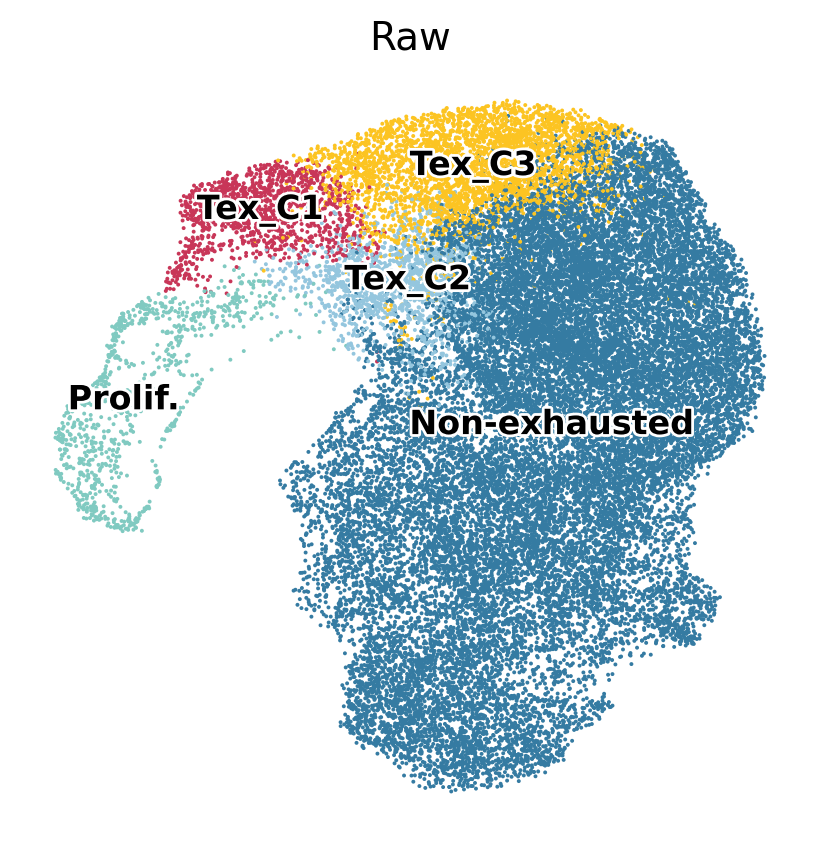

In [53]:

custom_palette = ['#357ba2', '#80cac1', '#c83658','#94c6de', '#fcc422']
adata_Dsc.obs['Dsc'] = pd.Categorical(adata_Dsc.obs['Dsc'], ordered=True)
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata_Dsc,
        color="Dsc",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="Raw",
        palette=custom_palette,
        wspace=0.5,
        add_outline=False,
        size=8,
        legend_loc="on data",
        save="_Dsc_Dsc_cluster.pdf",
        alpha = 1
    )


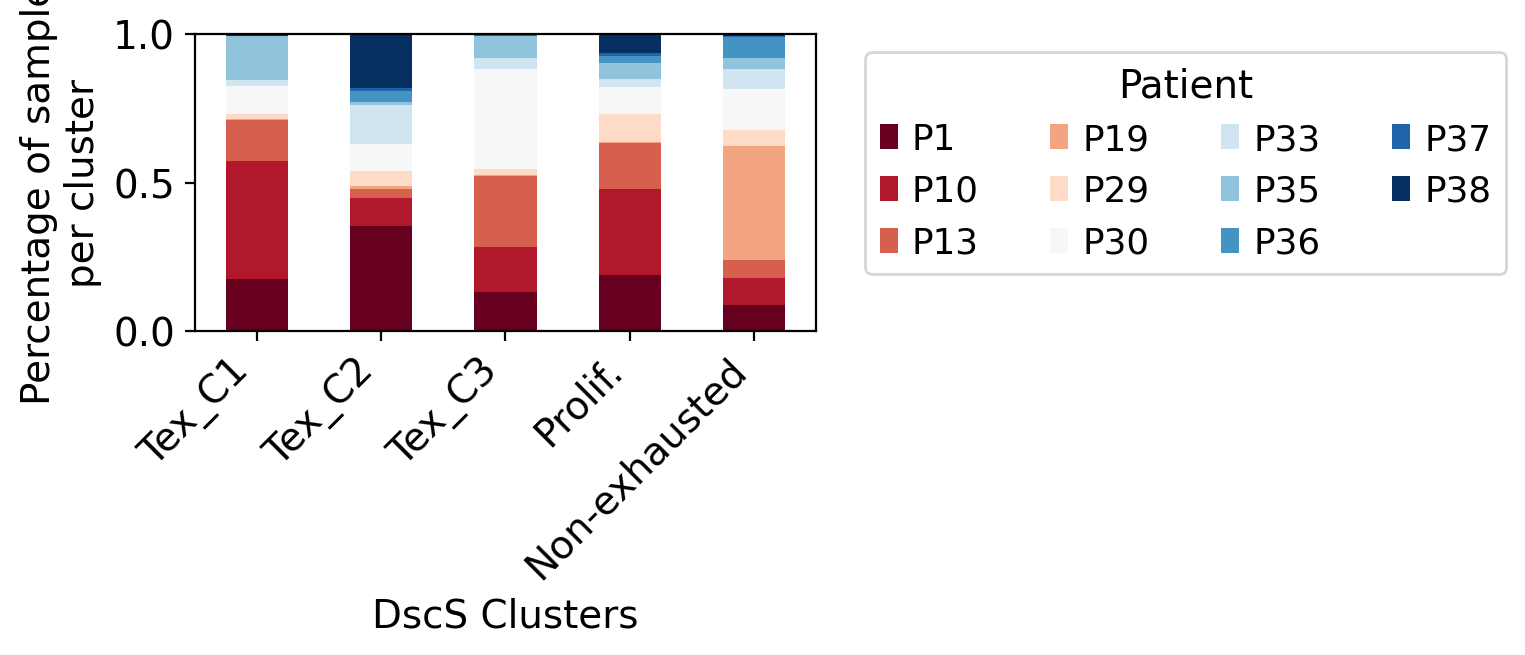

In [120]:


class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Circle(xy=center, radius=height / 4)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

counts = adata_Dsc.obs.groupby(['Dsc', 'patient']).size().unstack(fill_value=0)

custom_order = ['Tex_C1', 'Tex_C2', 'Tex_C3', 'Prolif.', 'Non-exhausted']

counts = counts.reindex(custom_order)

percentage = counts.div(counts.sum(axis=1), axis=0)

ax = percentage.plot(kind='bar', stacked=True, figsize=(8, 3.5), colormap='RdBu')  # 示例颜色映射
ax.set_ylabel("Percentage of samples\nper cluster")
ax.set_xlabel("DscS Clusters")
ax.set_ylim(0, 1)

plt.xticks(rotation=45, ha="right")
plt.grid(False)
plt.legend(title='Patient', loc='best', bbox_to_anchor=(1.05, 1.), ncol=4, handler_map={mpatches.Rectangle: HandlerCircle()})
plt.tight_layout()
plt.show()

# Fig.3b

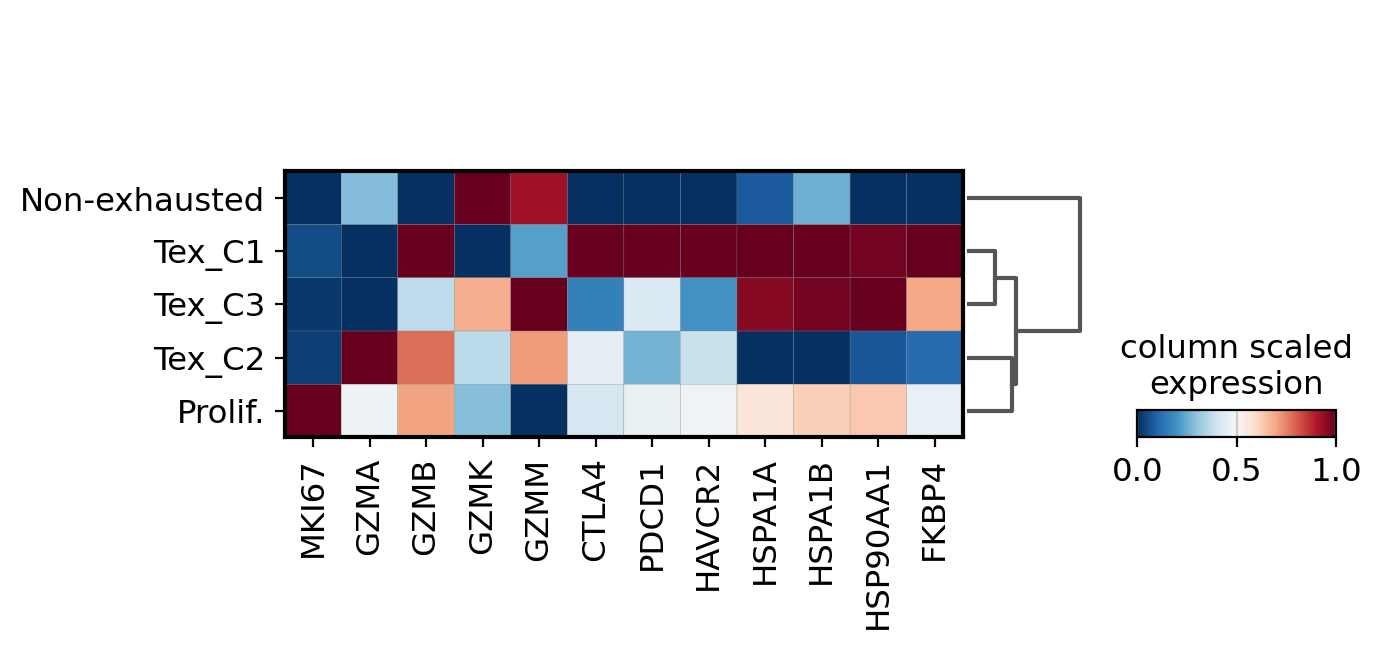

In [55]:
genes_of_interest = [
    'MKI67',"GZMA",'GZMB', "GZMK",'GZMM','CTLA4',
    "PDCD1", "HAVCR2",
    "HSPA1A", "HSPA1B",'HSP90AA1','FKBP4'
]
sc.pl.matrixplot(
    adata,
    genes_of_interest,
    "Dsc_cluster",
    dendrogram=True,
    cmap="RdBu_r",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

# Fig.3f-scTour

In [56]:
!pip install scikit-misc

In [57]:
!pip install sctour

In [58]:
adata.obs['treatment'] = adata.obs['sample'].apply(lambda x: x.split('.')[1])

In [59]:
adata1 = adata[adata.obs['treatment'] == 'post'].copy()
adata2 = adata1[adata1.obs['patient'] != 'P19'].copy()

In [60]:
#adata2 = adata

In [61]:
adataraw=sc.read_h5ad('/content/drive/MyDrive/scanpy/GSE179994/CD8.h5ad')
print(adataraw)

AnnData object with n_obs × n_vars = 59656 × 17277
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellid', 'patient', 'sample', 'celltype', 'cluster', 'response', 'response2', 'biosite'
    layers: 'counts'


In [62]:
import scanpy as sc

obs_indices = adataraw.obs_names.isin(adata2.obs_names)
var_indices = adataraw.var_names.isin(adata2.var_names)
filtered_raw_data = adataraw[obs_indices, var_indices]
filtered_raw_data = filtered_raw_data[adata2.obs_names, :]
filtered_raw_data = filtered_raw_data[:, adata2.var_names]
adata2.X = filtered_raw_data.X

In [63]:
sc.pp.calculate_qc_metrics(adata2, percent_top=None, log1p=False, inplace=True)

In [64]:
import sctour as sct
sc.pp.highly_variable_genes(adata2, flavor='seurat_v3', n_top_genes=1000, subset=True)

In [65]:
adata2.X = adata2.X.astype('float32')

In [66]:

# Initialize the Trainer with specific parameters
tnode = sct.train.Trainer(adata2, loss_mode='nb', alpha_recon_lec=0.5, alpha_recon_lode=0.5)

# Train the model
tnode.train()

Epoch 400: 100%|██████████| 400/400 [12:04<00:00,  1.81s/epoch, train_loss=258, val_loss=253]


In [67]:
adata2.obs['ptime'] = tnode.get_time()

In [68]:
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.5, alpha_predz=0.5)
adata2.obsm['X_TNODE'] = mix_zs

In [69]:
adata2.obsm['X_VF'] = tnode.get_vector_field(adata2.obs['ptime'].values, adata2.obsm['X_TNODE'])

In [70]:
adata2 = adata2[np.argsort(adata2.obs['ptime'].values), :]
sc.pp.neighbors(adata2, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata2, min_dist=0.1)

In [71]:
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)

In [72]:
adata2

AnnData object with n_obs × n_vars = 15445 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellid', 'patient', 'sample', 'celltype', 'cluster', 'response', 'response2', 'biosite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'HSP_CLASS', 'leiden_res_ori_0.02', 'leiden_res_ori_0.50', 'leiden_res_ori_1.20', 'Raw', 'Dsc_cluster', 'DscC', 'treatment', 'ptime'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'highly_variable_rank', 'va

In [73]:
adata2.obs["scTourC"] = adata2.obs["DscC"].map(
    {
        "0": "CD8T_Naive",
        "1": "OTHER",
        "2": "OTHER",
        "3": "OTHER",
        "4": "OTHER",
        "5": "OTHER",
        "6": "Tex_C2",
        "7": "OTHER",
        "8": "Tex_C1",
        "9": "OTHER",
        "10": "OTHER",
        "11": "OTHER",
        "12": "OTHER"

    }
)

In [ ]:
#adata2.obs['ptime'] = sct.train.reverse_time(adata2.obs['ptime'].values)

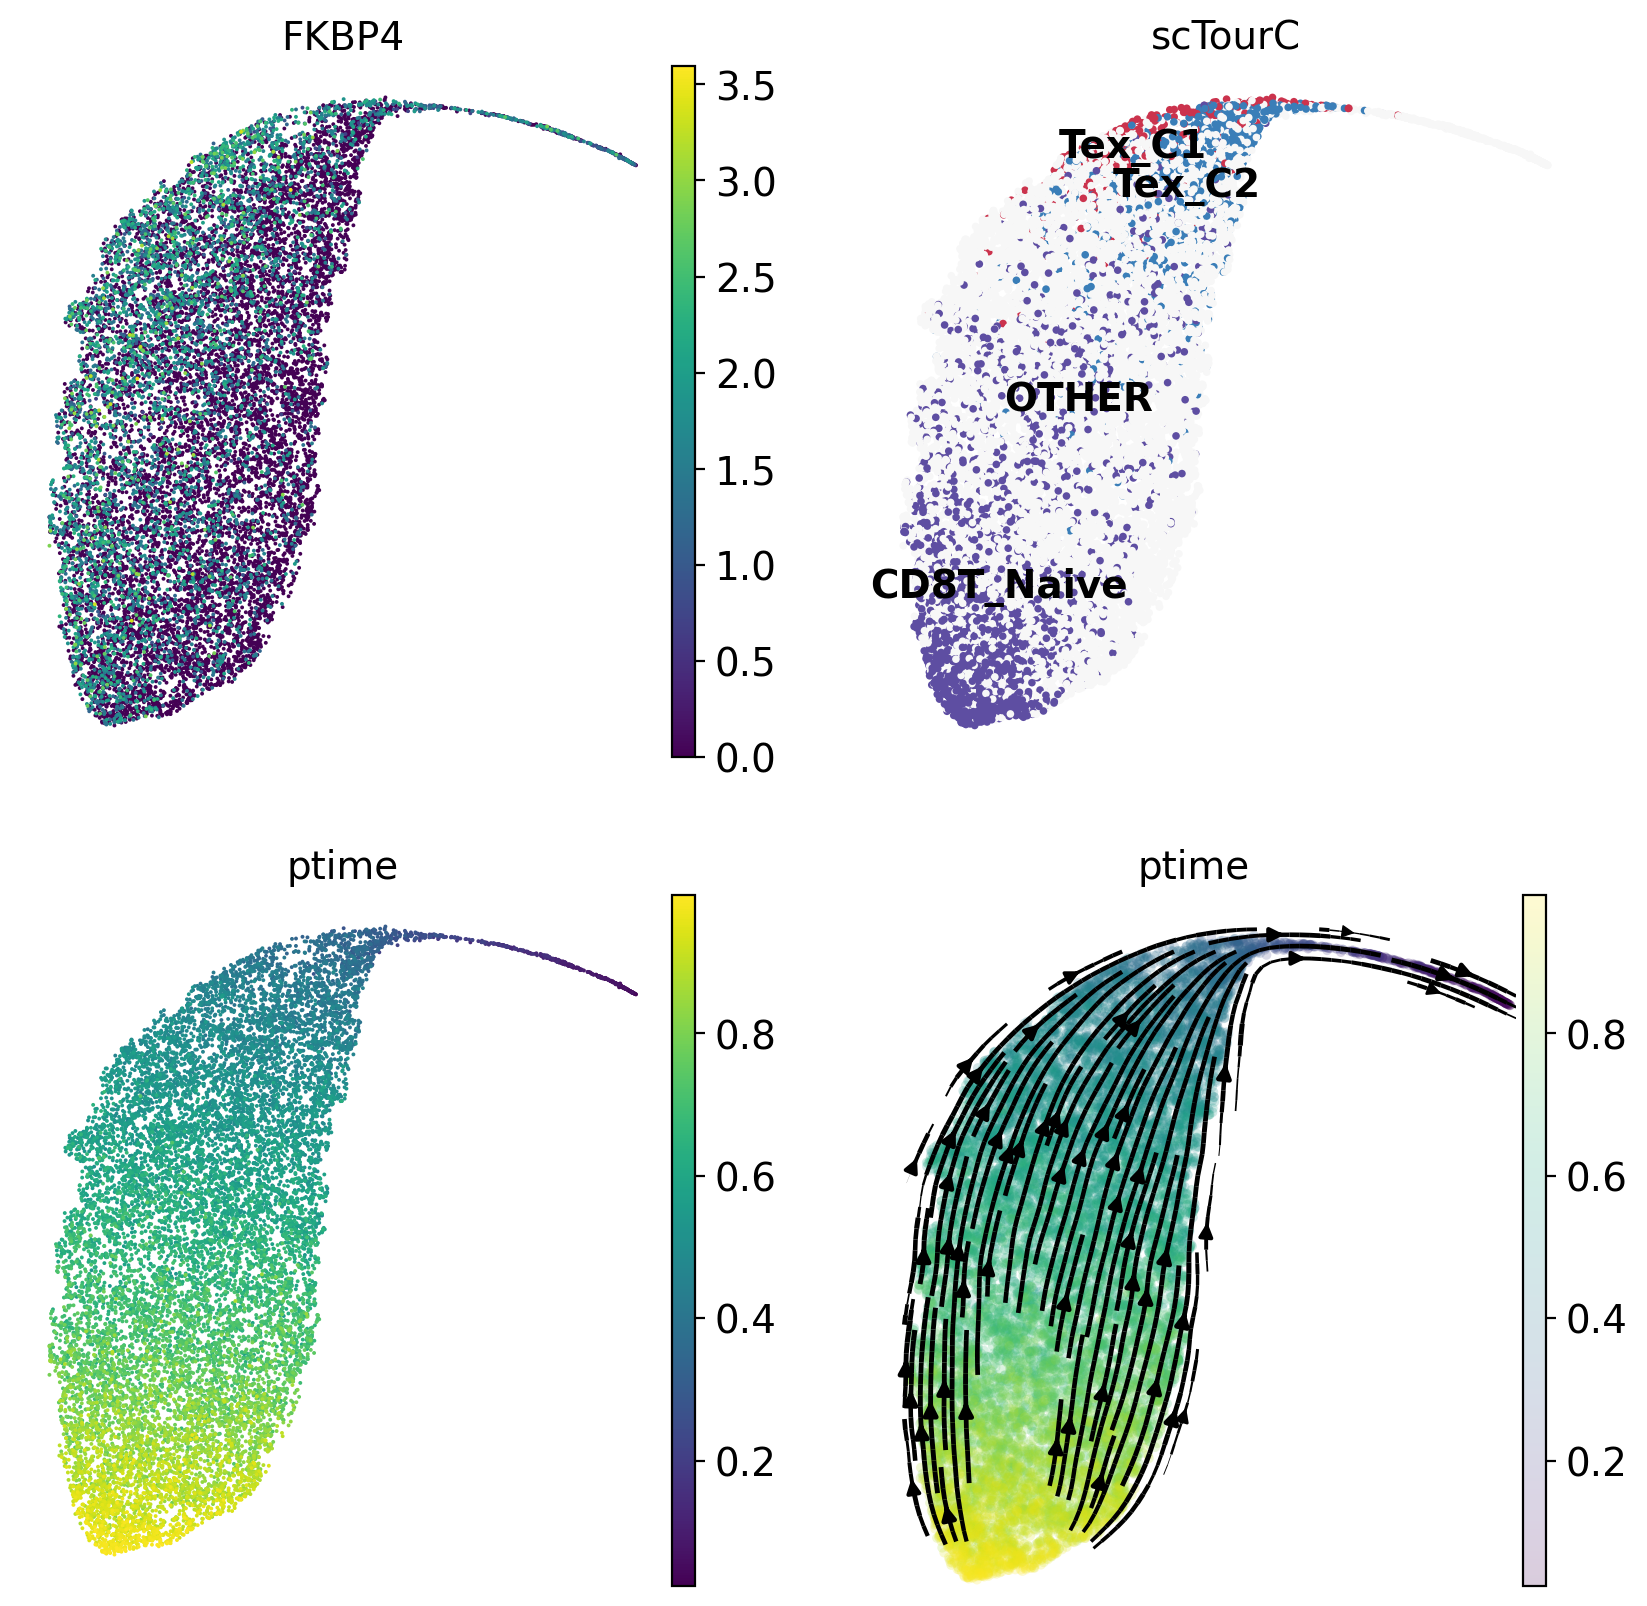

In [75]:
adata2.uns['scTourC_colors'] = ['#5e4ea2','#f7f7f7', '#cb334d', '#3a7eb8']
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.umap(adata2, color='FKBP4', ax=axs[0, 0], legend_loc='on data', show=False, frameon=False)
sc.pl.umap(adata2, color='scTourC', ax=axs[0, 1], legend_loc='on data', show=False, frameon=False, size = 30)
sc.pl.umap(adata2, color='ptime', ax=axs[1, 0], show=False, frameon=False)
sct.vf.plot_vector_field(adata2, reverse=True, zs_key='X_TNODE', vf_key='X_VF', use_rep_neigh='X_TNODE', color='ptime', show=False, ax=axs[1, 1], legend_loc='none', frameon=False, size=50, alpha=0.2)
plt.show()

# Fig.3g

In [76]:
!pip install matplotlib-venn

In [88]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

In [89]:
file_path = '/content/drive/MyDrive/scanpy/GSE179994/TCR_data.csv'
df = pd.read_csv(file_path)
print(df.head())

                       cellid  \
0  P1.tr.1.AAACCTGCACATGACT-1   
1  P1.tr.1.AAACCTGCAGATCGGA-1   
2  P1.tr.1.AAACCTGCAGATGGGT-1   
3  P1.tr.1.AAACCTGGTCGGATCC-1   
4  P1.tr.1.AAACCTGGTTAAGATG-1   

                                            clone.id  
0  TRAV9-2_TGTGCTCTGAGTGATCGGGTTGGTGGTACTAGCTATGG...  
1  TRAV8-4_TGTGCTGTGCTCAACCAGGCAGGAACTGCTCTGATCTT...  
2  TRAV23/DV6_TGTGCAGCAAGCATTGGGGAAACCAGTGGCTCTAG...  
3  TRAV41_TGTGCTGCCTATAACACCGACAAGCTCATCTTT_TRAJ3...  
4  TRAV14/DV4_TGTGCAATGAGGGGGATGTACAGCAGTGCTTCCAA...  


In [92]:
import pandas as pd
import scanpy as sc

Tex_ALL = adata.obs[adata.obs['cluster'] == "Tex"].index
Tex_ALL

Index(['P1.ut.AAATGCCCAACACGCC-1', 'P1.ut.AACCGCGAGCCTATGT-1',
       'P1.ut.AACTCCCTCTTACCGC-1', 'P1.ut.AACTCTTTCCATGAGT-1',
       'P1.ut.ACACCCTTCAAACGGG-1', 'P1.ut.ACACCGGTCCTTTCTC-1',
       'P1.ut.ACACCGGTCTGTCAAG-1', 'P1.ut.ACGATACCAGGGTACA-1',
       'P1.ut.ACGCAGCGTAAGGGCT-1', 'P1.ut.ACGCCAGGTGATAAGT-1',
       ...
       'P38.tr.1.TTAGGACCAAGAAAGG-1', 'P38.tr.1.TTAGTTCTCTTGTTTG-1',
       'P38.tr.1.TTATGCTCACGCTTTC-1', 'P38.tr.1.TTCGAAGAGCAACGGT-1',
       'P38.tr.1.TTCTCAATCTTGTTTG-1', 'P38.tr.1.TTCTCCTGTAAGTTCC-1',
       'P38.tr.1.TTGCCGTAGGAACTGC-1', 'P38.tr.1.TTGCGTCAGAAACCAT-1',
       'P38.tr.1.TTGGAACGTCTAAACC-1', 'P38.tr.1.TTTACTGAGCCTTGAT-1'],
      dtype='object', length=3747)

In [93]:
df = pd.read_csv("/content/drive/MyDrive/scanpy/GSE179994/TCR_data.csv")

clone_ids_Tex_ALL = df[df['cellid'].isin(Tex_ALL)]['clone.id'].drop_duplicates()
clone_ids_Tex_ALL

68       TRAV1-2_TGTGCTGTGAGAGGCCGGGATAACTATGGTCAGAATTT...
108      TRAV20_TGTGCTGTGCGGCCTCGTGGGGATAACTATGGTCAGAAT...
149      TRAV16_TGTGCTCACATGGTAGGAAACAAACTGGTCTTT_TRAJ4...
157      TRAV38-2/DV8_TGTGCTTATAACACCGACAAGCTCATCTTT_TR...
214      TRAV4_TGCCTCCCCTACAGCAGTGCTTCCAAGATAATCTTT_TRA...
                               ...                        
50140    TRAV36/DV7_TGTGCTCCTACGTACAATAACAATGACATGCGCTT...
50198    TRAV1-2_TGTGCTGTGAGAGATGAAACAGGAGGAAGCTACATACC...
50317    TRAV13-2_TGTGCAGAGAACGGACTCTCAGGATACAGCACCCTCA...
50548    TRAV14/DV4_TGTGCAATGAAGACTTCTGGTTCTGCAAGGCAACT...
50582    TRAV19_TGTGCTCTGAGTGAGTTATATGCTGGTGGTACTAGCTAT...
Name: clone.id, Length: 730, dtype: object

In [94]:
filtered_cellids = df[df['clone.id'].isin(clone_ids_Tex_ALL)]['cellid'].unique()
adata_TCR_Tex_ALL = adata[adata.obs.index.isin(filtered_cellids)].copy()
print(adata_TCR_Tex_ALL)

AnnData object with n_obs × n_vars = 6971 × 15330
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellid', 'patient', 'sample', 'celltype', 'cluster', 'response', 'response2', 'biosite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'HSP_CLASS', 'leiden_res_ori_0.02', 'leiden_res_ori_0.50', 'leiden_res_ori_1.20', 'Raw', 'Dsc_cluster', 'DscC', 'treatment'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Dsc_cluster_colors', 'HSP_C

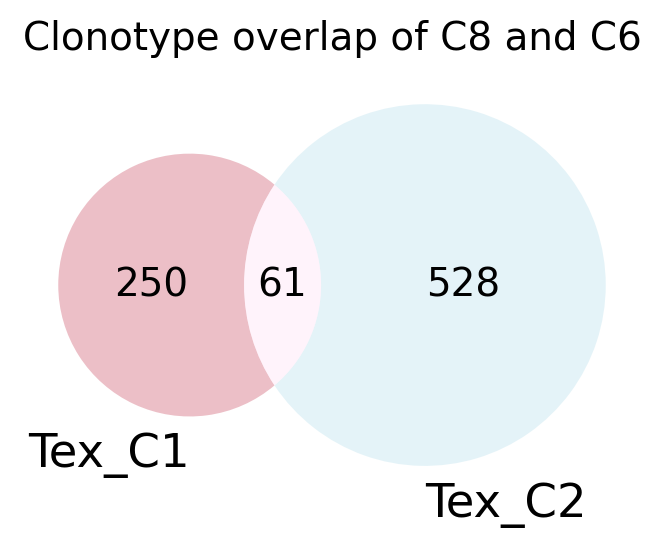

In [97]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

df = pd.read_csv("/content/drive/MyDrive/scanpy/GSE179994/TCR_data.csv")

Tex_C1 = adata.obs[adata.obs['Dsc_cluster'] == "Tex_C1"].index
Tex_C2 = adata.obs[adata.obs['Dsc_cluster'] == "Tex_C2"].index

clone_ids_Tex_C1 = df[df['cellid'].isin(Tex_C1)]['clone.id'].drop_duplicates()
clone_ids_Tex_C2 = df[df['cellid'].isin(Tex_C2)]['clone.id'].drop_duplicates()

plt.figure(figsize=(4, 4))
v = venn2([set(clone_ids_Tex_C1), set(clone_ids_Tex_C2)],
          set_labels=('Tex_C1', 'Tex_C2'),
          set_colors=("#d06073", "#bde2ee"))
plt.title("Clonotype overlap of C8 and C6")
plt.show()

# Fig.3h&i&j

In [105]:
cells_filtered = adata_TCR_Tex_ALL.obs_names
genes_filtered = adata_TCR_Tex_ALL.var_names
adata_raw_subset = adataraw[cells_filtered, genes_filtered]
adata_raw_subset = adata_raw_subset[adata_TCR_Tex_ALL.obs_names, adata_TCR_Tex_ALL.var_names]
adata_TCR_Tex_ALL.X = adata_raw_subset.X.copy()
print(adata_TCR_Tex_ALL.X)

  (0, 8)	1.0
  (0, 10)	1.0
  (0, 15)	2.0
  (0, 24)	1.0
  (0, 26)	1.0
  (0, 37)	1.0
  (0, 49)	1.0
  (0, 50)	1.0
  (0, 54)	1.0
  (0, 71)	5.0
  (0, 91)	2.0
  (0, 95)	2.0
  (0, 137)	2.0
  (0, 139)	1.0
  (0, 140)	1.0
  (0, 147)	1.0
  (0, 168)	1.0
  (0, 171)	1.0
  (0, 180)	1.0
  (0, 182)	2.0
  (0, 186)	1.0
  (0, 187)	1.0
  (0, 188)	2.0
  (0, 211)	3.0
  (0, 220)	2.0
  :	:
  (6970, 15114)	1.0
  (6970, 15131)	1.0
  (6970, 15132)	1.0
  (6970, 15169)	1.0
  (6970, 15173)	2.0
  (6970, 15179)	2.0
  (6970, 15193)	1.0
  (6970, 15209)	1.0
  (6970, 15250)	4.0
  (6970, 15274)	1.0
  (6970, 15283)	1.0
  (6970, 15286)	1.0
  (6970, 15287)	1.0
  (6970, 15307)	2.0
  (6970, 15308)	5.0
  (6970, 15309)	1.0
  (6970, 15310)	27.0
  (6970, 15311)	17.0
  (6970, 15312)	6.0
  (6970, 15313)	12.0
  (6970, 15314)	5.0
  (6970, 15315)	1.0
  (6970, 15317)	1.0
  (6970, 15318)	5.0
  (6970, 15320)	10.0


In [106]:
adata_TCR_Tex_ALL.obs['treatment'] = adata_TCR_Tex_ALL.obs['sample'].apply(lambda x: x.split('.')[1])
sc.pp.normalize_total(adata_TCR_Tex_ALL, target_sum=1e4)
sc.pp.log1p(adata_TCR_Tex_ALL)
adata_TCR_Tex_ALL.raw = adata_TCR_Tex_ALL.copy()
sc.pp.highly_variable_genes(adata_TCR_Tex_ALL, n_top_genes=1000)
import scanpy.external as sce
sc.pp.scale(adata_TCR_Tex_ALL, max_value=10)
sc.tl.pca(adata_TCR_Tex_ALL)#
sc.external.pp.bbknn(adata_TCR_Tex_ALL, neighbors_within_batch=1,batch_key="patient")
sc.tl.umap(adata_TCR_Tex_ALL)
for res in [1.0, 0.4, 0.5]:
    sc.tl.leiden(
        adata_TCR_Tex_ALL, key_added=f"leiden_res_ori_{res:4.2f}", resolution=res, flavor="igraph"
    )

In [109]:
adata_TCR_Tex_ALL.obs["C"] = adata_TCR_Tex_ALL.obs["leiden_res_ori_0.40"].map(
    {
        "0": "Tex",
        "1": "Texp2",
        "2": "Texp1",
        "4": "Texp1",
        "3": "Prolif.",

    }
)

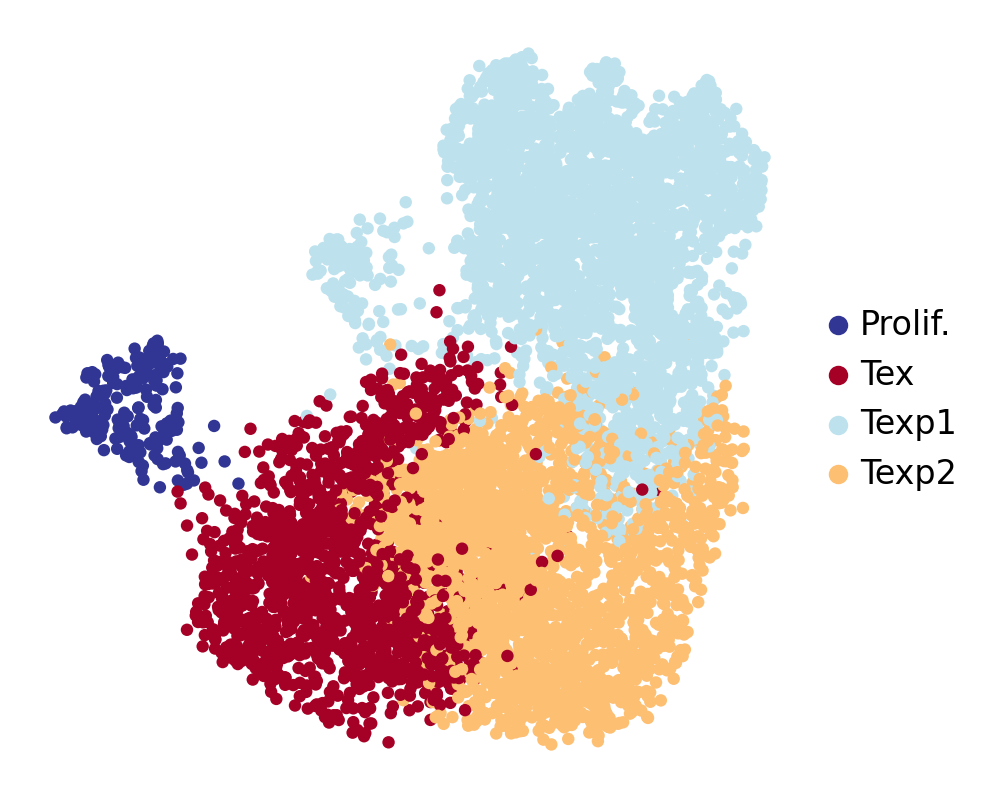

In [112]:
plt.rcParams['axes.titlesize'] = 16
custom_palette = ['#313695','#a50026','#bde2ee' ,'#fdbf72']
with rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(
        adata_TCR_Tex_ALL,
        color="C",
        add_outline=False,
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="",
        palette=custom_palette,
        wspace=0.5,
        size=80,
    )

In [114]:
def create_custom_colormap(colors):
    colors_rgb = [matplotlib.colors.to_rgb(color) for color in colors]
    positions = np.linspace(0, 1, len(colors))
    cdict = {
        'red': [(pos, color[0], color[0]) for pos, color in zip(positions, colors_rgb)],
        'green': [(pos, color[1], color[1]) for pos, color in zip(positions, colors_rgb)],
        'blue': [(pos, color[2], color[2]) for pos, color in zip(positions, colors_rgb)]
    }
    custom_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=cdict)
    return custom_cmap

colors = ['#ffffff','#7bb6d6' ,'#d0e4ef', '#f9efe9',
'#f9c2a7' ,'#f4a683', '#cf5347','#67001f']

custom_cmap2 = create_custom_colormap(colors)

In [117]:
adata_TCR_Tex_ALL = adata_TCR_Tex_ALL.raw.to_adata()
X_dense = adata_TCR_Tex_ALL.X
min_value = np.min(X_dense)
if min_value < 0:
    X_dense += abs(min_value)
adata_TCR_Tex_ALL.X = X_dense
new_min_value = np.min(adata_TCR_Tex_ALL.X)
print(f"Original min value: {min_value}, Adjusted min value: {new_min_value}")

Original min value: 0.0, Adjusted min value: 0.0


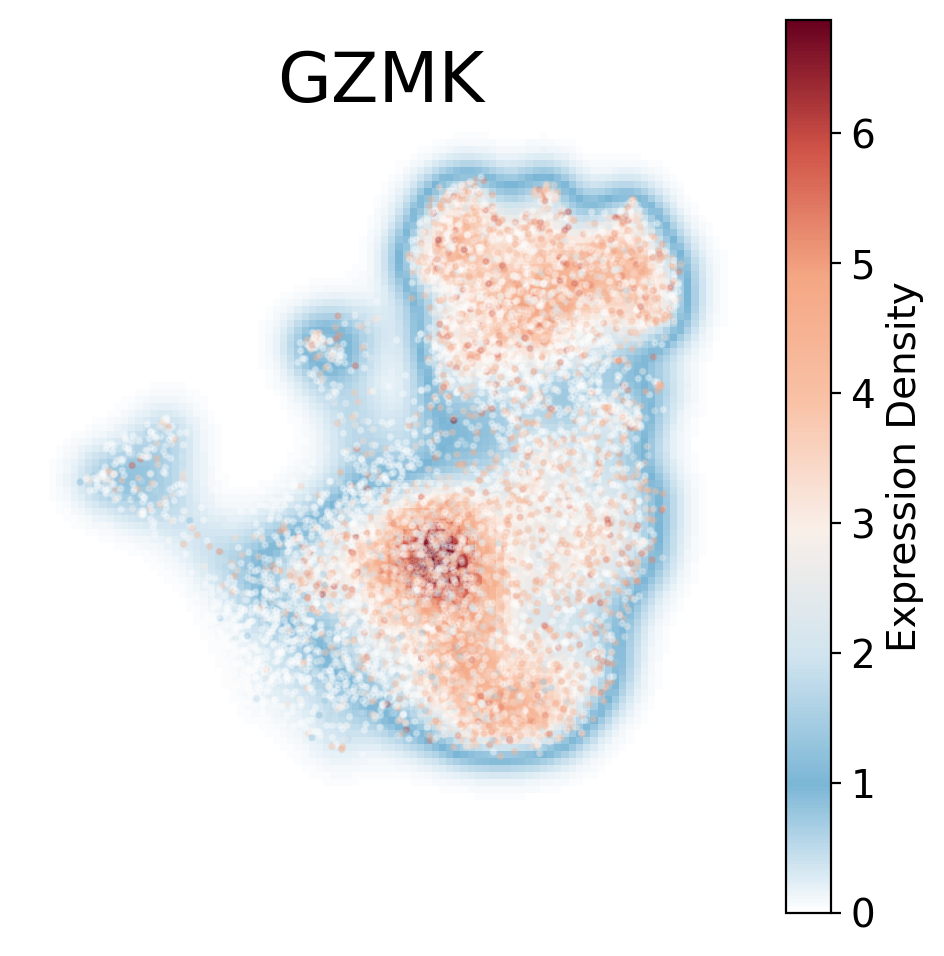

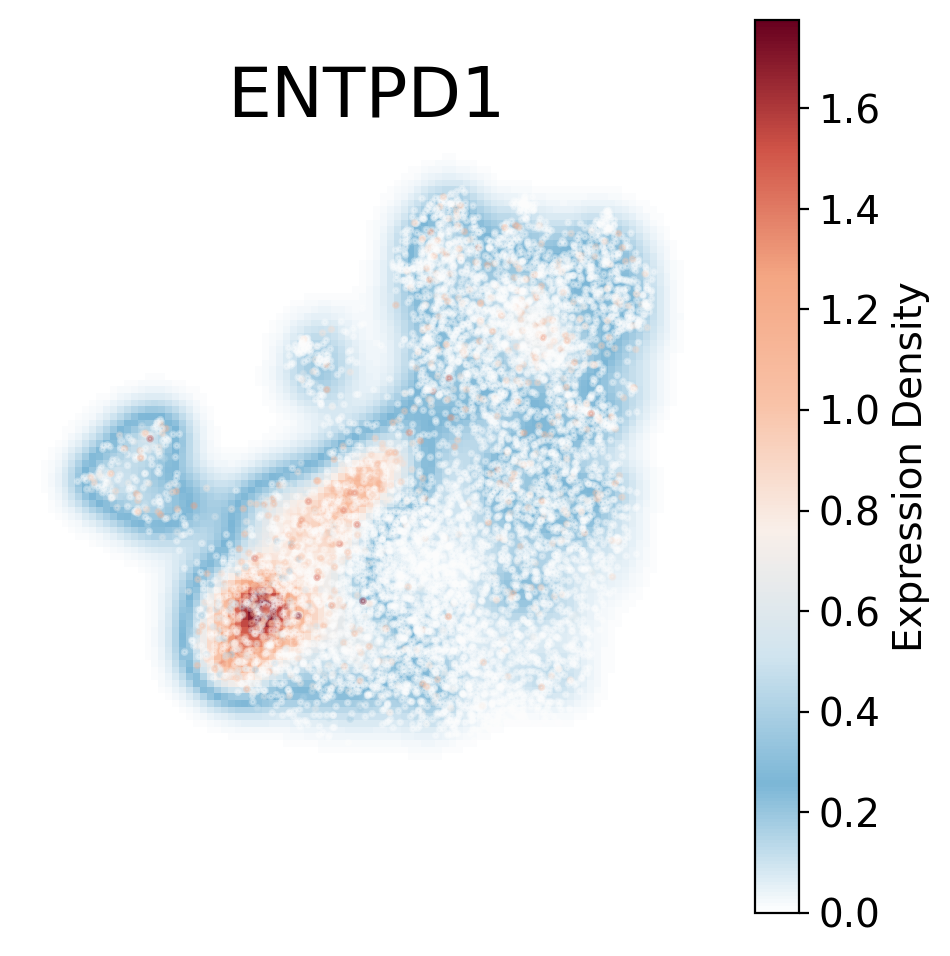

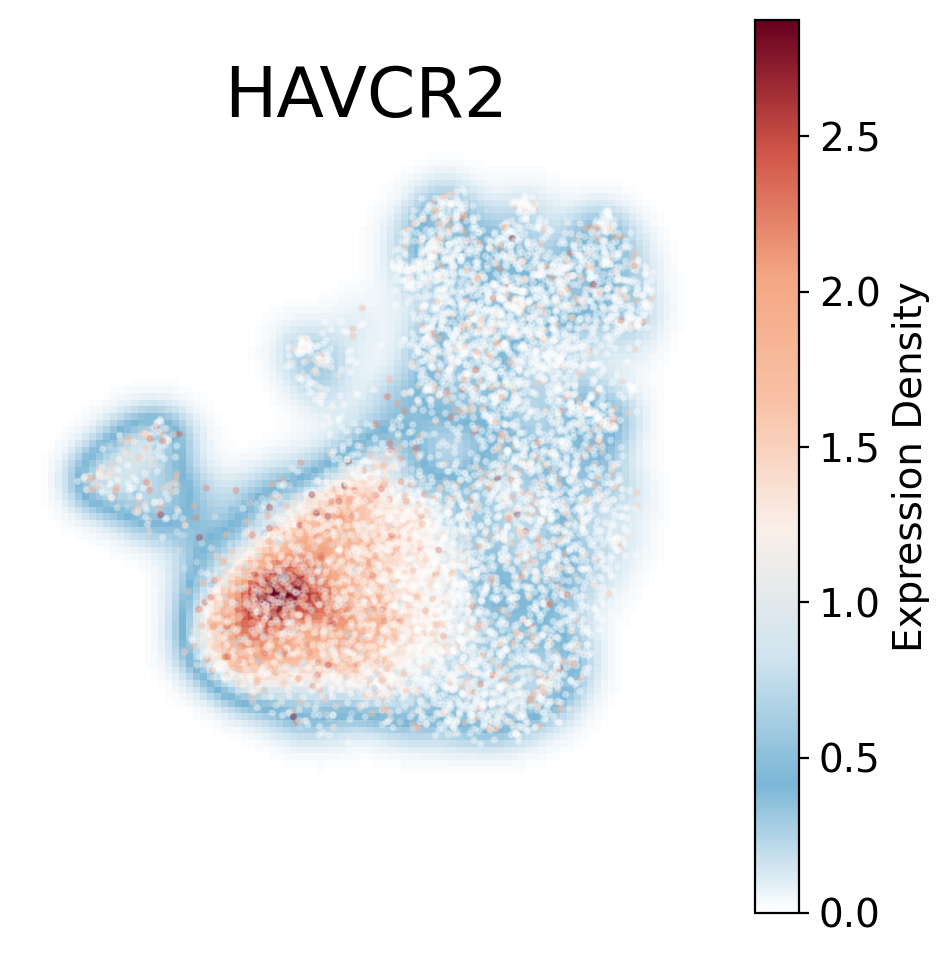

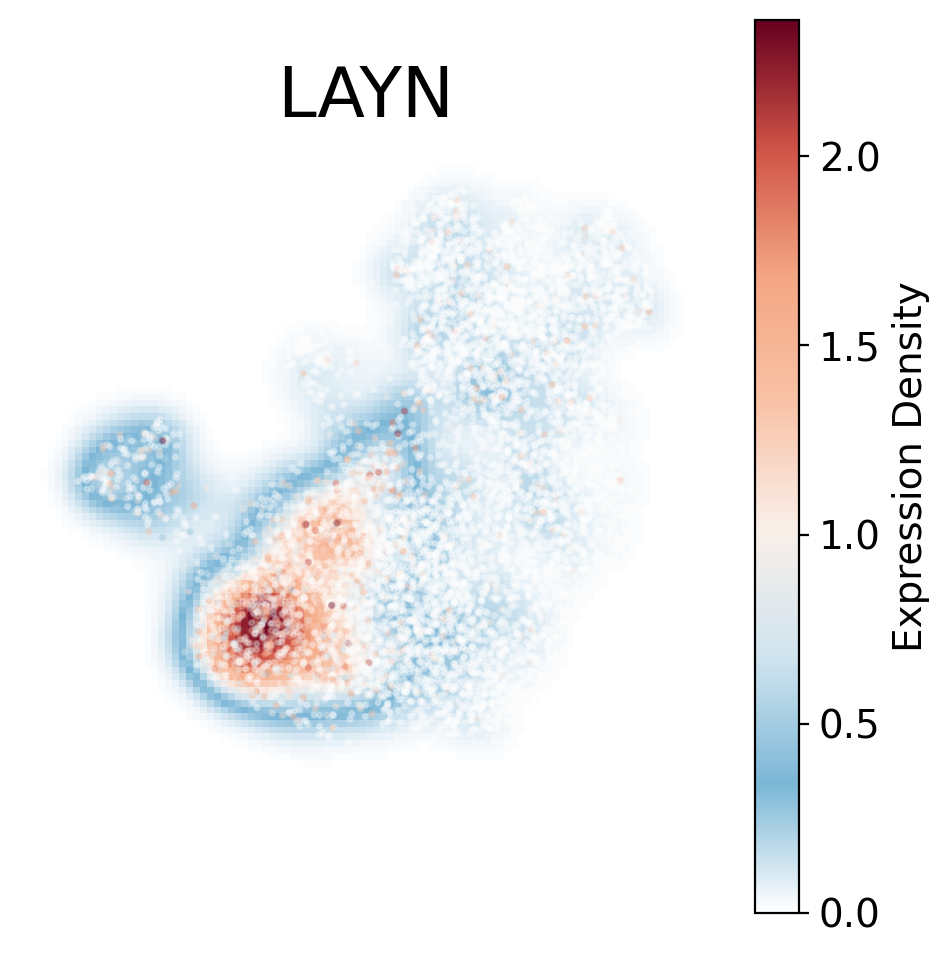

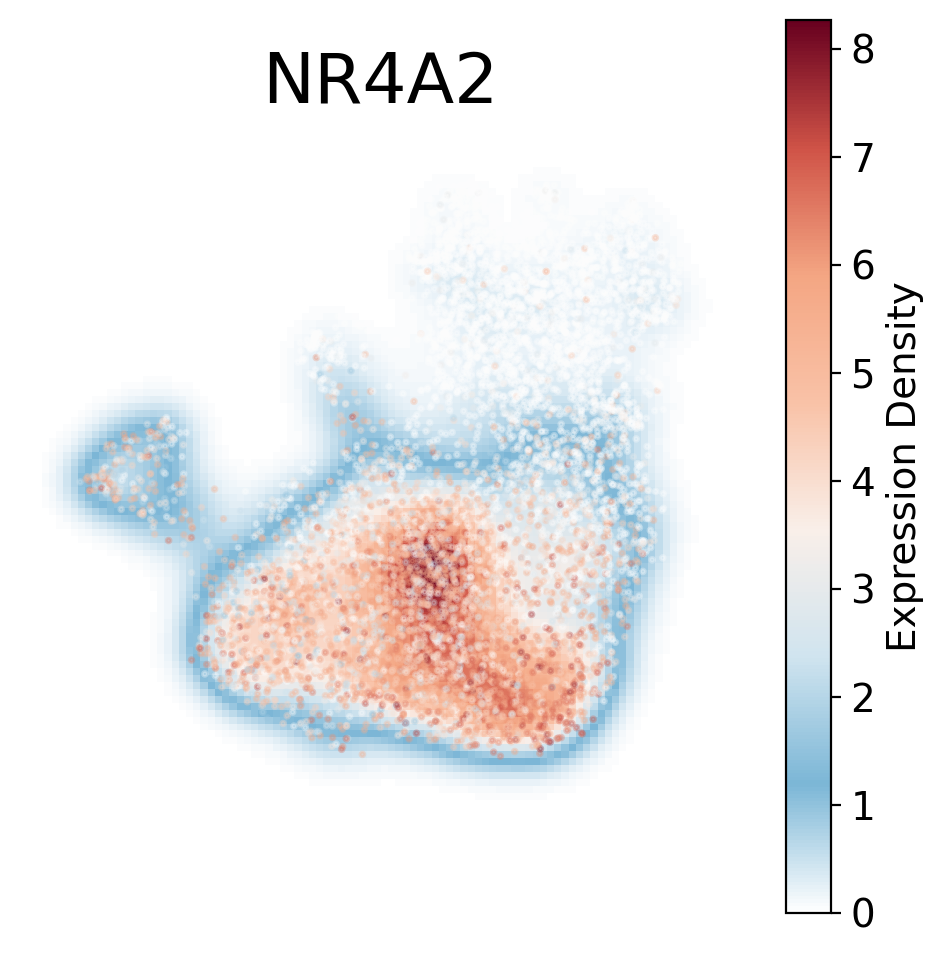

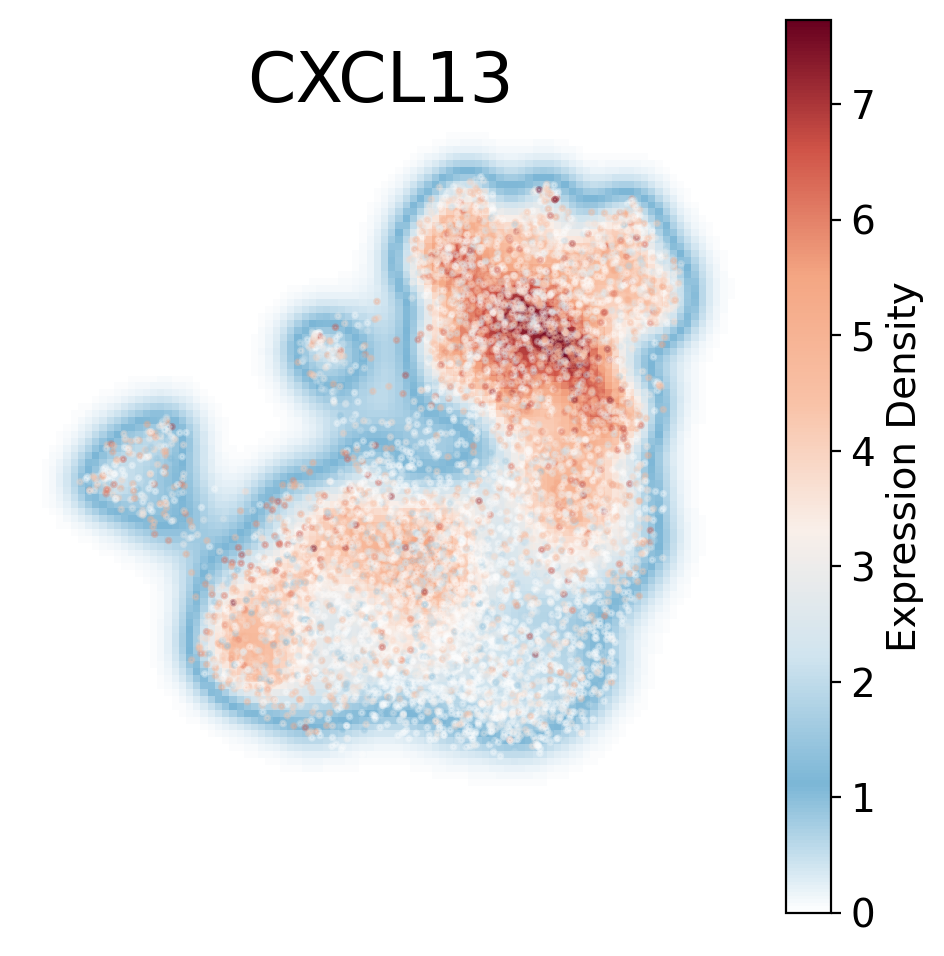

In [118]:
from scipy.ndimage import gaussian_filter

save_dir = "/content/drive/MyDrive/scanpy/GSE179994/TCR/density"
os.makedirs(save_dir, exist_ok=True)

genes = ['GZMK', 'ENTPD1', 'HAVCR2', 'LAYN', 'NR4A2', 'CXCL13']
umap_coords = adata_TCR_Tex_ALL.obsm['X_umap']

for gene in genes:
    gene_expression = adata_TCR_Tex_ALL[:, gene].X.toarray().flatten()
    x_min, x_max = np.min(umap_coords[:,0]), np.max(umap_coords[:,0])
    y_min, y_max = np.min(umap_coords[:,1]), np.max(umap_coords[:,1])
    expansion_ratio = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x = np.linspace(x_min - expansion_ratio * x_range, x_max + expansion_ratio * x_range, 100)
    y = np.linspace(y_min - expansion_ratio * y_range, y_max + expansion_ratio * y_range, 100)
    x_grid, y_grid = np.meshgrid(x, y)
    z_grid = np.zeros(x_grid.shape)
    for i in range(umap_coords.shape[0]):
        nearest_x = np.argmin(np.abs(x - umap_coords[i, 0]))
        nearest_y = np.argmin(np.abs(y - umap_coords[i, 1]))
        z_grid[nearest_y, nearest_x] += gene_expression[i]

    density = gaussian_filter(z_grid, sigma=3)

    plt.figure(figsize=(5, 5))
    plt.imshow(density, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), cmap=custom_cmap2)
    plt.colorbar(label='Expression Density')
    plt.scatter(umap_coords[:,0], umap_coords[:,1], c=gene_expression, cmap=custom_cmap2, s=3, alpha=0.3)

    plt.title(gene, fontsize = 25)
    plt.xticks([])
    plt.yticks([])
    plt.box(True)
    plt.tight_layout()
    plt.axis('off')
    plt.legend('', frameon=False)
    plt.show()

# Fig.3m

In [ ]:
from scipy.sparse import issparse
from scipy.stats import pearsonr

Correlation between FKBP4 and HSP90AA1: 0.8841282982812863, p-value: 2.3316560478097637e-07


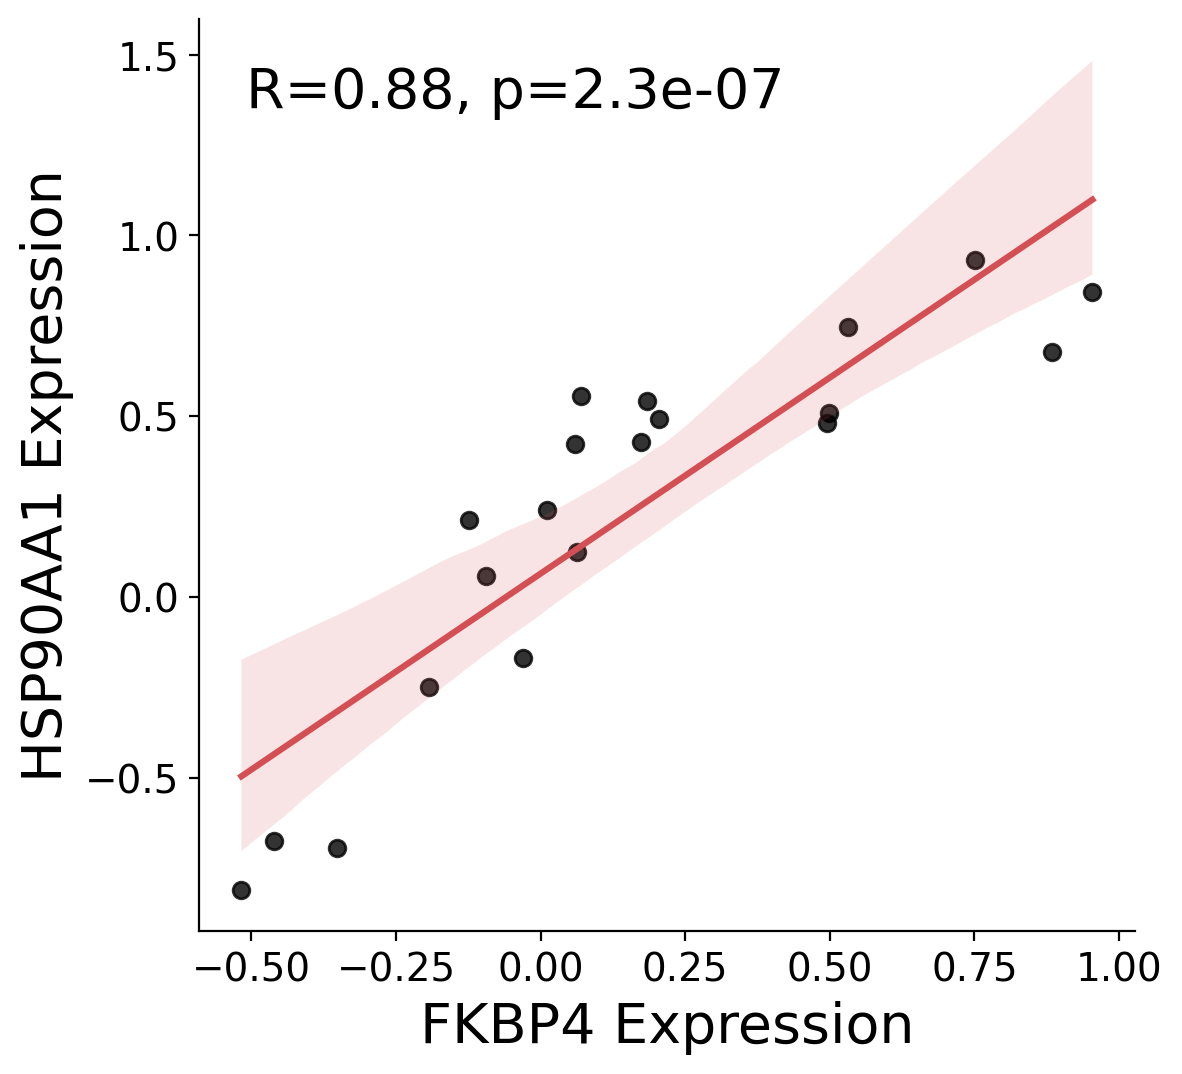

In [152]:
gene1 = 'FKBP4'
gene2 = 'HSP90AA1'

gene1_expression = adata[:, adata.var_names == gene1].X
gene2_expression = adata[:, adata.var_names == gene2].X

if issparse(gene1_expression):
    gene1_expression = gene1_expression.toarray().squeeze()
gene1_expression = gene1_expression.ravel()

if issparse(gene2_expression):
    gene2_expression = gene2_expression.toarray().squeeze()
gene2_expression = gene2_expression.ravel()

gene1_series = pd.Series(gene1_expression, index=adata.obs.index)
gene2_series = pd.Series(gene2_expression, index=adata.obs.index)

adata.obs[gene1] = gene1_series
adata.obs[gene2] = gene2_series

adata.obs[gene1] = adata.obs[gene1].astype(float)
adata.obs[gene2] = adata.obs[gene2].astype(float)

sample_means = adata.obs.groupby('sample')[[gene1, gene2]].mean()

correlation, p_value = pearsonr(sample_means[gene1], sample_means[gene2])
print(f"Correlation between {gene1} and {gene2}: {correlation}, p-value: {p_value}")

fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(
    x=sample_means[gene1],
    y=sample_means[gene2],
    line_kws={"color": "#d34f54"},
    scatter_kws={"color": "black"},
    ci=95,
    color='grey',
    ax=ax
)

plt.title(f'')
plt.xlabel(f'{gene1} Expression',fontsize = 20)
plt.ylabel(f'{gene2} Expression',fontsize = 20)
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.text(0.05, 0.95, f'R={correlation:.2f}, p={p_value:.2g}', transform=ax.transAxes, verticalalignment='top',fontsize = 20)

plt.show()